This notebook contains the experiments done with the `fast.ai` library. Reasons - 

- Extremely fast
- Incorporates modern deep learning practices (like one cycle policy, learning rate annealing and so on)

The training time has been reduce to just **5 seconds** with same architecture (ResNet50). This is promising I think. I ran the experiments on a GCP `n1-standard-4` machine type (with Tesla P4). The previous experiments (mixed precision policy) were also run on the same machine and the training time was 5-7 times more on average. 

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from fastai.vision import *
from fastai.metrics import error_rate

In [39]:
!pwd

/home/jupyter/.local/share/Trash/files/histology_classifier/Sayak_Notebooks


In [40]:
!ls /home/jupyter/histology_classifier/data_chec_resized

Bladder  Brain	dat.csv  Kidney  LI  Liver  Lung  pool	SI  Skin


In [41]:
path = '/home/jupyter/histology_classifier/data_chec_resized/pool'
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(max_lighting=0., p_lighting=0.0), valid_pct=0.2,
                                   size=(256, 192), bs=16).normalize(imagenet_stats)

> The above function creates a `ImageDataBunch` object from the `labels.csv` file (`dat.csv) (which all the fast.ai models need for training (computer vision)) and at the same time does the following - 
- Reads the image data as specified in the .csv file
- Creates the labels
- Applies data augmentation
- Prepares the validation set
- Normalizes the pixels

Appreciation does not harm. Does it? 

The following help function to show the training data is simply amazing. 

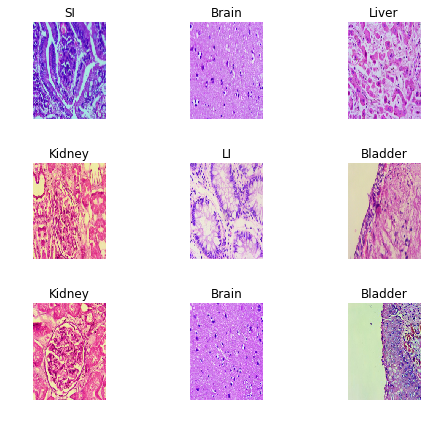

In [42]:
data.show_batch(rows=3, figsize=(7,6))

In [43]:
print(data.classes)
len(data.classes),data.c

['Bladder', 'Brain', 'Kidney', 'LI', 'Liver', 'Lung', 'SI', 'Skin']


(8, 8)

## Initial experiments with ResNet34 with 10 epochs

In [44]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# The magic of one_cycle_policy
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.619462,1.986137,0.812500,00:01
1,2.370301,1.585554,0.562500,00:01
2,1.910473,0.841646,0.062500,00:01
3,1.501732,0.474364,0.062500,00:01
4,1.247431,0.346008,0.062500,00:01
5,1.040260,0.275892,0.062500,00:01
6,0.869374,0.249378,0.062500,00:01
7,0.744874,0.228907,0.062500,00:01
8,0.661594,0.215754,0.125000,00:01
9,0.584485,0.208098,0.062500,00:01


> Look at the training time. 

In [45]:
learn.save('stage-1')

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Where the model is getting confused. Extremely helpful in interpreting things. 

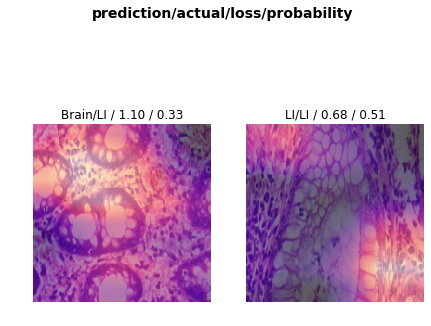

In [47]:
interp.plot_top_losses(2, figsize=(7,6))

**Fine-tuning** the model. 

In [48]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.223624,0.783369,0.250000,00:01


In [50]:
learn.load('stage-1');

In [51]:
# Differential learning rates
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.201920,0.209384,0.062500,00:01
1,0.145395,0.223165,0.062500,00:01


## Now comes RestNet50

In [52]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Leslie Smith's learning rate finding technique as discussed in the paper: https://arxiv.org/abs/1506.01186

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


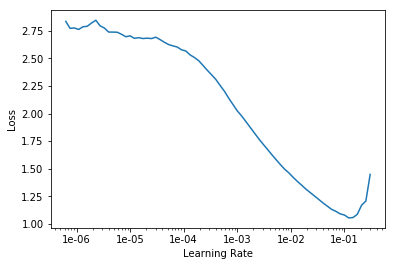

In [53]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.221357,1.896986,0.750000,00:01
1,1.662012,1.000468,0.437500,00:01
2,1.159768,0.445018,0.125000,00:01
3,0.863881,0.284470,0.125000,00:01
4,0.690672,0.222246,0.062500,00:01
5,0.561114,0.210750,0.062500,00:01
6,0.481395,0.182564,0.062500,00:01
7,0.412436,0.162858,0.062500,00:01
8,0.365993,0.170041,0.062500,00:01


In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

> Speed has a name and it is called **fast.ai**. 

In [ ]:
learn.export('/home/jupyter/histology_classifier/Sayak_Notebooks/model_pkl/resnet50.pkl')